In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

Load data

In [2]:
X = pd.read_pickle('X.pkl')
y = pd.read_pickle('y.pkl')

In [3]:
X

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking
0,1.196985,0,0.736228,0,-1.536815,1,0.060647,1.213386,-1.682295,1,0
2,0.348517,0,-0.576628,0,-1.536815,0,-1.109034,0.243823,-1.931104,1,1
3,-0.924186,1,-0.835752,0,-1.536815,0,-0.563940,1.213386,0.059365,1,0
5,2.469687,1,-1.643139,0,0.172757,1,-0.632077,1.469091,-1.184678,1,1
6,1.196985,1,-0.082117,0,-1.964208,0,-1.506498,0.039321,0.059365,1,0
...,...,...,...,...,...,...,...,...,...,...,...
293,0.178823,1,-0.906369,1,-0.254636,0,-0.915980,-0.695682,-0.189444,1,1
294,0.093976,0,-1.399261,1,0.001800,1,-1.188527,-0.182986,1.552216,1,1
295,-0.499951,0,1.821532,0,0.001800,0,0.117427,0.039321,0.556982,0,0
297,-1.348420,0,2.090153,0,0.001800,0,-1.358869,0.433162,0.805791,1,1


In [4]:
y

,death_event
0,1
2,1
3,1
5,1
6,1
...,...
293,0
294,0
295,0
297,0


### **Set up Logistic Regression model**
We want to set up our logistic regression by using a neural network. We will use one Linear Layer and the sigmoid function to transform our data in a range between 0 and 1.

In [5]:
class LogisticRegression(nn.Module): 
    def __init__(self, input_dimensions):
        super().__init__()
        self.linear = nn.Linear(in_features = input_dimensions, out_features = 1)

    def forward(self,x): # Define forard function which applies sigmoid function to our output 
        return torch.sigmoid(self.linear(x))

So far, we will use the *binary cross-entropy-loss* (**BCELoss**). Later on, one can try different other loss functions.  
For a standard Logistic Regression without any regularization, we can use *Gradient Descent* as an optimization tool.

In [6]:
X_tensor = torch.tensor(X.values, dtype=torch.float32)
Y_tensor = torch.tensor(y.values, dtype=torch.float32).view(-1, 1)

## **Test different learning rates**

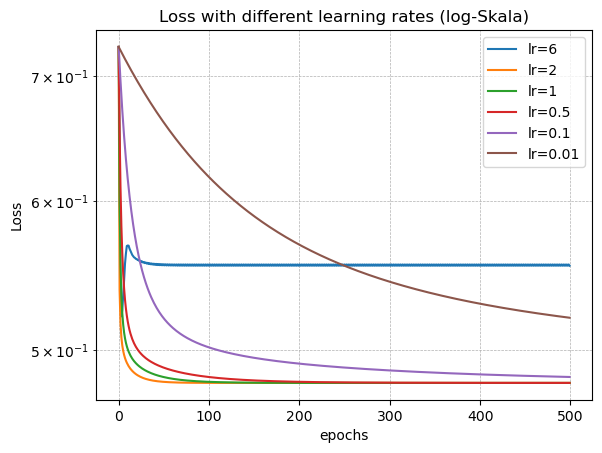

In [7]:
lr = [6, 2, 1, 0.5, 0.1, 0.01]
losses = []

for learning_rate in lr:
    torch.manual_seed(41)
    LR_model = LogisticRegression(input_dimensions=X.shape[1])

    loss_fun = nn.BCELoss() 
    optimizer = optim.SGD(LR_model.parameters(), lr=learning_rate)

    X_tensor = torch.tensor(X.values, dtype=torch.float32)
    Y_tensor = torch.tensor(y.values, dtype=torch.float32).view(-1, 1)

    epochs = 500

    # We wish to save the trajectory of weight, bias and loss
    hist_W = []
    hist_b = []
    hist_loss = []

    #Trainigsloop bleibt auch bei mehrschichtigen Netzen gleich
    for epoch in range(epochs):
        pred = LR_model(X_tensor)                       # Forward pass
        loss = loss_fun(pred, Y_tensor)                 # Compute loss

        optimizer.zero_grad()   # Gradienten auf Null setzen
        loss.backward()         # Berechne den Gradienten
        optimizer.step()        # Optimierungsschritt nach Gradient Descent 

        hist_loss.append(loss.item())
    
    losses.append(hist_loss)

for hist_loss in losses:
    plt.plot(hist_loss)

plt.xlabel("epochs")
plt.ylabel("Loss")
plt.yscale("log")  # <-- log-Skalierung der y-Achse
plt.legend([f"lr={l}" for l in lr])
plt.title("Loss with different learning rates (log-Skala)")
plt.grid(True, which="both", linestyle="--", linewidth=0.5)

## **Introduce Regularization**
First, we build up a complete model, including a fit() and pred() function.

In [8]:
class LR_complete(nn.Module): 
    def __init__(self, input_dimensions):
        super().__init__()
        self.linear = nn.Linear(in_features = input_dimensions, out_features = 1)

    def forward(self,x): # Define forard function which applies sigmoid function to our output 
        return torch.sigmoid(self.linear(x))

    def fit(self, X_train, y_train, epochs=500, learning_rate = 0.005, regularization = None, alpha = 1):
        X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
        y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)

        loss_fun = nn.BCELoss() 
        if regularization == "l1":
            optimizer = optim.Adam(self.parameters(), lr=learning_rate)            
        else:
            optimizer = optim.SGD(self.parameters(), lr=learning_rate)
        
        for epoch in range(epochs):
            pred = self.forward(X_train_tensor)
            base_loss = loss_fun(pred, y_train_tensor)

            if regularization == 'l1':
                l1_penalty = torch.sum(torch.abs(self.linear.weight))
                reg_term = alpha * l1_penalty

            elif regularization == 'l2':
                l2_penalty = torch.sum(self.linear.weight ** 2)
                reg_term = alpha * l2_penalty
            
            else:
                reg_term = torch.tensor(0.0)
            
            loss = base_loss + reg_term

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            #if epoch % 100 == 0:
                #print("Epoch ", epoch, " : ",base_loss)

        self.final_weights = self.linear.weight.data
        self.final_bias = self.linear.bias.data
        self.final_base_loss = base_loss.item()
        self.final_total_loss = base_loss.item() + reg_term.item()

        if regularization == 'l1':
            self.l1_norm = l1_penalty.item()
        elif regularization == 'l2':
            self.l2_norm = torch.sqrt(l2_penalty).item()
    
    def pred(self, X):
        X_tensor = torch.tensor(X.values, dtype=torch.float32)
        return self.forward(X_tensor)


**Next: Try L1 and L2-Regularization and see if we can obtain better models**

First of all we need to estimate the best regularization parameter $\alpha$. To do so we plot the L-Curve and choose a reasonable $\alpha$.

### **L-Curve for L2-Regularization**

Alpha = 0.003 -> Beste Lernrate = 1.00000
Alpha = 0.005 -> Beste Lernrate = 1.00000
Alpha = 0.010 -> Beste Lernrate = 0.69519
Alpha = 0.050 -> Beste Lernrate = 0.33598
Alpha = 0.100 -> Beste Lernrate = 0.23357
Alpha = 0.150 -> Beste Lernrate = 0.16238
Alpha = 0.200 -> Beste Lernrate = 0.23357
Alpha = 0.300 -> Beste Lernrate = 0.11288
Alpha = 0.500 -> Beste Lernrate = 0.16238
Alpha = 1.000 -> Beste Lernrate = 0.11288
Alpha = 2.000 -> Beste Lernrate = 0.06723
Alpha = 5.000 -> Beste Lernrate = 0.10000
Alpha = 10.000 -> Beste Lernrate = 0.06723
Fehler bei alpha=20, lr=0.1: all elements of input should be between 0 and 1
Fehler bei alpha=20, lr=0.06723357536499334: all elements of input should be between 0 and 1
Alpha = 20.000 -> Beste Lernrate = 0.10000


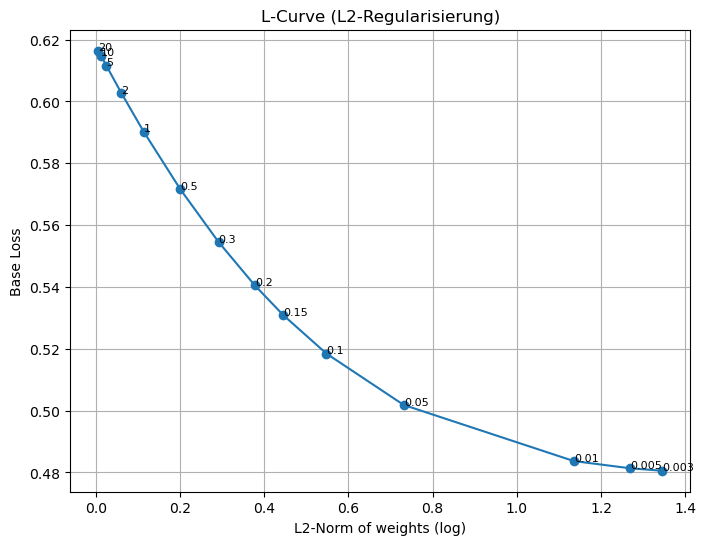

In [9]:
alphas = [0.003, 0.005, 0.01, 0.05, 0.1, 0.15, 0.2, 0.3, 0.5, 1, 2, 5, 10, 20]      
l2_norms = []
base_losses = []

for alpha in alphas:
    model_total_losses = []
    model_l_losses = []
    model_base_losses = []
    if alpha < 2:
        lrs = np.logspace(0, -3, num = 20)
    else:
        lrs = np.logspace(-1, -6, num = 30)
    for lr in lrs:
        try:
            model = LR_complete(input_dimensions=X.shape[1])
            model.fit(X, y, regularization='l2', alpha=alpha, learning_rate=lr)

            # Prüfen auf NaN oder zu hohe Werte
            if np.isnan(model.final_total_loss) or model.final_total_loss > 1e6:
                raise ValueError("Unplausibler Verlust")

            model_total_losses.append(model.final_total_loss)
            model_l_losses.append(model.l2_norm)
            model_base_losses.append(model.final_base_loss)

        except Exception as e:
            print(f"Fehler bei alpha={alpha}, lr={lr}: {e}")
            continue  # nächsten Lernratenwert versuchen

    # Falls keine gültige Kombination gefunden wurde, überspringen
    if not model_total_losses:
        print(f"Keine gültigen Ergebnisse für alpha={alpha}")
        continue

    i = np.argmin(model_total_losses)

    print("Alpha = %.3f -> Beste Lernrate = %.5f" % (alpha, lrs[i]))
    
    l2_norms.append(model_l_losses[i])
    base_losses.append(model_base_losses[i])

plt.figure(figsize=(8, 6))
plt.plot(l2_norms, base_losses, marker='o')
plt.xscale('linear')
plt.yscale('linear')
plt.xlabel("L2-Norm of weights (log)")
plt.ylabel("Base Loss")
plt.title("L-Curve (L2-Regularisierung)")
plt.grid(True)
for i, txt in enumerate(alphas):
    plt.annotate(f"{txt}", (l2_norms[i], base_losses[i]), fontsize=8)
plt.show()

Choose **$\alpha = 5$** for L2-regularization.

Alpha = 0.001 -> Beste Lernrate = 0.48329
Alpha = 0.010 -> Beste Lernrate = 0.02637
Alpha = 0.025 -> Beste Lernrate = 0.00616
Alpha = 0.050 -> Beste Lernrate = 0.00298
Alpha = 0.075 -> Beste Lernrate = 0.00428
Alpha = 0.100 -> Beste Lernrate = 0.00428
Alpha = 0.300 -> Beste Lernrate = 0.00428
Alpha = 1.000 -> Beste Lernrate = 0.00144
Alpha = 10.000 -> Beste Lernrate = 0.00144


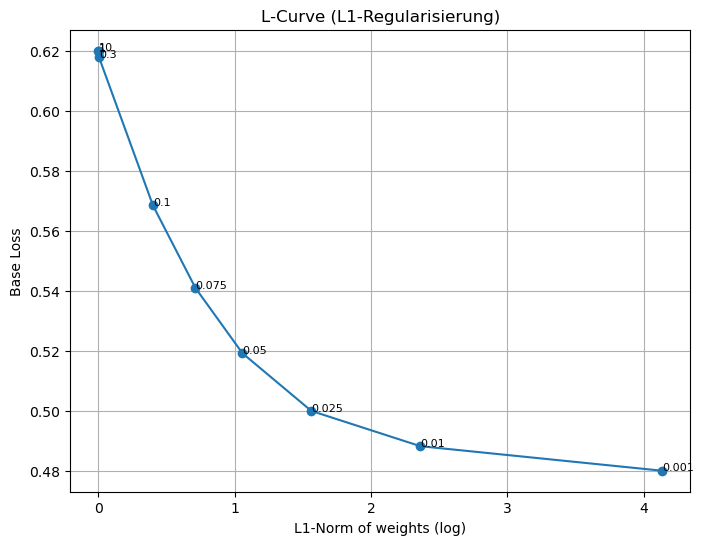

In [10]:
alphas = [0.001, 0.01, 0.025, 0.05, 0.075, 0.1, 0.3, 1, 10]      
l1_norms = []
base_losses = []

for alpha in alphas:
    model_total_losses = []
    model_l_losses = []
    model_base_losses = []
    if alpha <= 1:
        lrs = np.logspace(0, -3, num = 20)
    else:
        lrs = np.logspace(-2, -6, num = 20)
    for lr in lrs:
        try:
            model = LR_complete(input_dimensions=X.shape[1])
            model.fit(X, y, regularization='l1', alpha=alpha, learning_rate=lr)

            # Prüfen auf NaN oder zu hohe Werte
            if np.isnan(model.final_total_loss) or model.final_total_loss > 1e6:
                raise ValueError("Unplausibler Verlust")

            model_total_losses.append(model.final_total_loss)
            model_l_losses.append(model.l1_norm)
            model_base_losses.append(model.final_base_loss)

        except Exception as e:
            print(f"Fehler bei alpha={alpha}, lr={lr}: {e}")
            continue  # nächsten Lernratenwert versuchen

    # Falls keine gültige Kombination gefunden wurde, überspringen
    if not model_total_losses:
        print(f"Keine gültigen Ergebnisse für alpha={alpha}")
        continue

    i = np.argmin(model_total_losses)
    print("Alpha = %.3f -> Beste Lernrate = %.5f" % (alpha, lrs[i]))

    
    l1_norms.append(model_l_losses[i])
    base_losses.append(model_base_losses[i])

plt.figure(figsize=(8, 6))
plt.plot(l1_norms, base_losses, marker='o')
plt.xscale('linear')
plt.yscale('linear')
plt.xlabel("L1-Norm of weights (log)")
plt.ylabel("Base Loss")
plt.title("L-Curve (L1-Regularisierung)")
plt.grid(True)
for i, txt in enumerate(alphas):
    plt.annotate(f"{txt}", (l1_norms[i], base_losses[i]), fontsize=8)
plt.show()

Choose $\alpha = $ for L1-Regularization.

## **Compare models with different regularizations by using crossvalidation**

In [11]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score


kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)


all_aucs = []
all_accuracies = []

for regularization, learning_rate, alpha in zip([None, 'l1', 'l2'], [0.5, 0.006, 1], [None, 0.025, 0.05]):
    accuracies = []

    roc_aucs = []

    # Cross-Validation Schleife
    for fold, (train_index, val_index) in enumerate(kf.split(X,y)):
        X_train_fold = X.iloc[train_index]
        y_train_fold = y.iloc[train_index]
        X_val_fold = X.iloc[val_index]
        y_val_fold = y.iloc[val_index]

        model = LR_complete(input_dimensions = X_train_fold.shape[1])

        model.fit(X_train_fold, y_train_fold, regularization = regularization, alpha = alpha, learning_rate = learning_rate)

        y_pred_fold = model.pred(X_val_fold)

        y_pred_fold = y_pred_fold.detach().numpy()

        y_pred_fold_classes = (y_pred_fold >= 0.5).astype(int)

        acc = accuracy_score(y_val_fold, y_pred_fold_classes)
        accuracies.append(acc)

        auc = roc_auc_score(y_val_fold, y_pred_fold)
        roc_aucs.append(auc)

        print(f"Fold {fold + 1}: Accuracy = {acc:.4f}, ROC AUC = {auc:.4f}")

    all_accuracies.append(accuracies)
    all_aucs.append(roc_aucs)
    

Fold 1: Accuracy = 0.8276, ROC AUC = 0.7056
Fold 2: Accuracy = 0.7931, ROC AUC = 0.8000
Fold 3: Accuracy = 0.7586, ROC AUC = 0.9056
Fold 4: Accuracy = 0.7241, ROC AUC = 0.6167
Fold 5: Accuracy = 0.7931, ROC AUC = 0.8278
Fold 6: Accuracy = 0.7500, ROC AUC = 0.9474
Fold 7: Accuracy = 0.8214, ROC AUC = 0.7661
Fold 8: Accuracy = 0.6071, ROC AUC = 0.3918
Fold 9: Accuracy = 0.6786, ROC AUC = 0.8125
Fold 10: Accuracy = 0.6786, ROC AUC = 0.7750
Fold 1: Accuracy = 0.8276, ROC AUC = 0.7722
Fold 2: Accuracy = 0.8276, ROC AUC = 0.7556
Fold 3: Accuracy = 0.7241, ROC AUC = 0.8944
Fold 4: Accuracy = 0.6552, ROC AUC = 0.5778
Fold 5: Accuracy = 0.8276, ROC AUC = 0.8278
Fold 6: Accuracy = 0.7500, ROC AUC = 0.9298
Fold 7: Accuracy = 0.8214, ROC AUC = 0.7836
Fold 8: Accuracy = 0.6071, ROC AUC = 0.4094
Fold 9: Accuracy = 0.7857, ROC AUC = 0.8188
Fold 10: Accuracy = 0.7143, ROC AUC = 0.7500
Fold 1: Accuracy = 0.8276, ROC AUC = 0.7722
Fold 2: Accuracy = 0.7931, ROC AUC = 0.7778
Fold 3: Accuracy = 0.7586, ROC

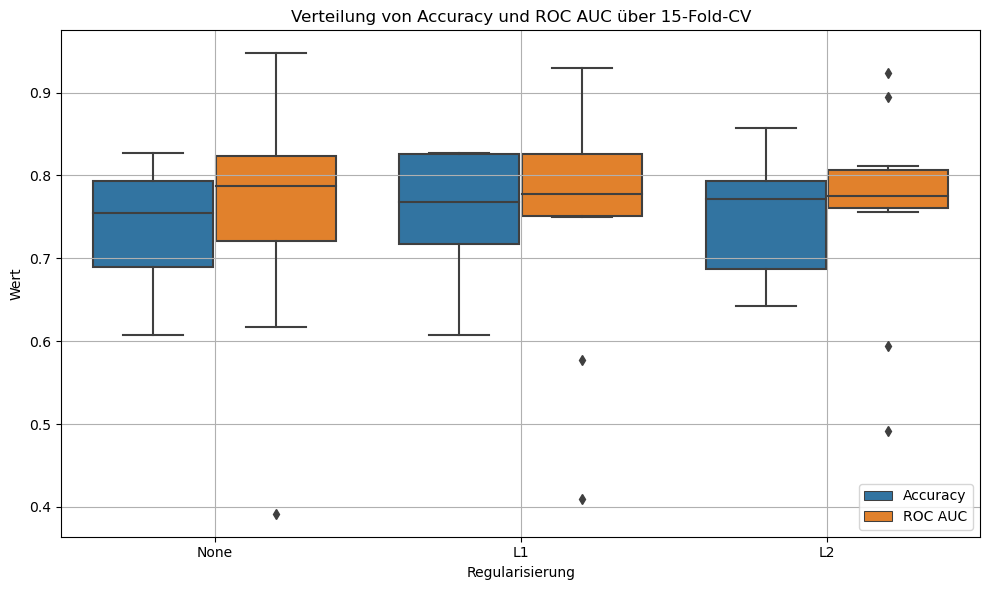

   Regularisierung    Metrik      Wert
0             None  Accuracy  0.827586
1             None  Accuracy  0.793103
2             None  Accuracy  0.758621
3             None  Accuracy  0.724138
4             None  Accuracy  0.793103
5             None  Accuracy  0.750000
6             None  Accuracy  0.821429
7             None  Accuracy  0.607143
8             None  Accuracy  0.678571
9             None  Accuracy  0.678571
10              L1  Accuracy  0.827586
11              L1  Accuracy  0.827586
12              L1  Accuracy  0.724138
13              L1  Accuracy  0.655172
14              L1  Accuracy  0.827586
15              L1  Accuracy  0.750000
16              L1  Accuracy  0.821429
17              L1  Accuracy  0.607143
18              L1  Accuracy  0.785714
19              L1  Accuracy  0.714286
20              L2  Accuracy  0.827586
21              L2  Accuracy  0.793103
22              L2  Accuracy  0.758621
23              L2  Accuracy  0.655172
24              L2  Accur

In [12]:
import seaborn as sns

# Labels für Regularisierungsarten
methods = ['None', 'L1', 'L2']

# Accuracy-Daten vorbereiten
acc_data = []
for i, method in enumerate(methods):
    for acc in all_accuracies[i]:
        acc_data.append({'Regularisierung': method, 'Metrik': 'Accuracy', 'Wert': acc})

# AUC-Daten vorbereiten
auc_data = []
for i, method in enumerate(methods):
    for auc in all_aucs[i]:
        auc_data.append({'Regularisierung': method, 'Metrik': 'ROC AUC', 'Wert': auc})

# Kombinieren
plot_data = pd.DataFrame(acc_data + auc_data)

# Plot
plt.figure(figsize=(10, 6))
sns.boxplot(data=plot_data, x='Regularisierung', y='Wert', hue='Metrik')
plt.title('Verteilung von Accuracy und ROC AUC über 15-Fold-CV')
plt.grid(True)
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()
print(plot_data)

We need to save the modell evaluation parameters in a DataFrame to use it, to compare all models later on.

In [13]:
import pandas as pd

models = ['LR', 'L1', 'L2']
data = []

for i, model in enumerate(models):
    for fold in range(len(all_accuracies[i])):
        data.append({
            'Modell': model,
            'Fold': fold + 1,           # Fold von 1 bis 10
            'ROC AUC': all_aucs[i][fold],
            'Accuracy': all_accuracies[i][fold]
        })

model_evaluation = pd.DataFrame(data)

Now we want to comapre the parameter values. To do so, we fit the model for all the data, without splitting it up. We plot the estimated coefficients and show for effects of regularization.

In [14]:
model_weights = {}
regularizations = [None, 'l1', 'l2']
learning_rates = [0.5, 0.006, 1]
alphas = [None, 0.025, 0.05]

for reg, lr, alpha in zip(regularizations, learning_rates, alphas):
    model = LR_complete(input_dimensions=X.shape[1])
    model.fit(X, y, regularization=reg, alpha=alpha, learning_rate=lr)
    
    weights = model.final_weights.detach().numpy().flatten()
    model_weights[reg if reg else 'None'] = weights


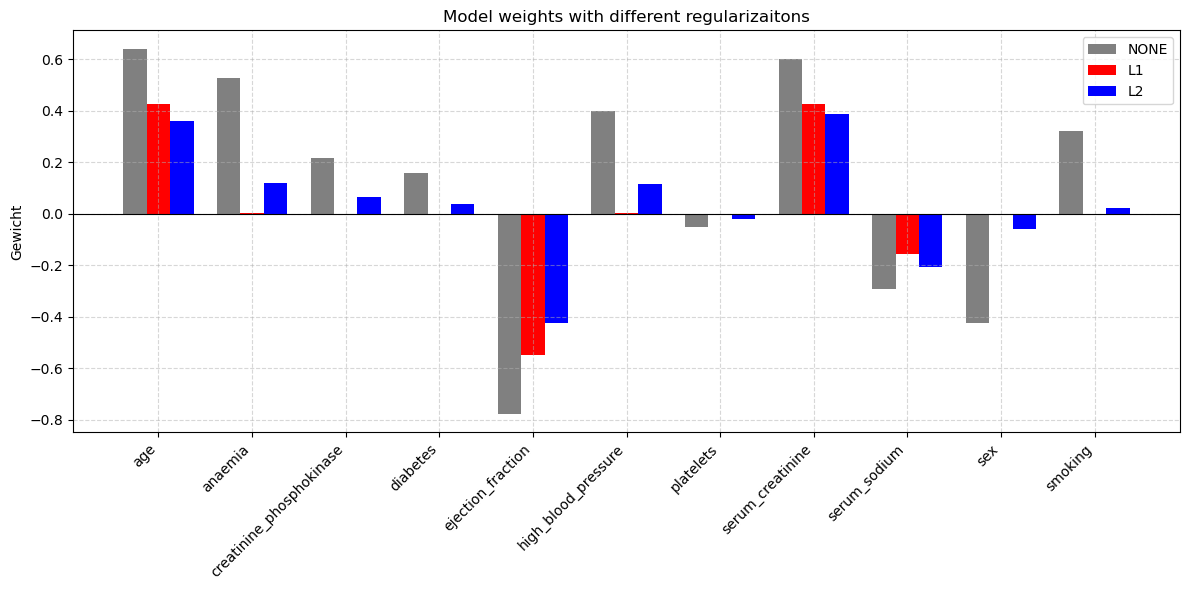

In [15]:
feature_names = X.columns
x = np.arange(len(feature_names))

plt.figure(figsize=(12, 6))

width = 0.25
offsets = {'None': -width, 'l1': 0, 'l2': width}
colors = {'None': 'gray', 'l1': 'red', 'l2': 'blue'}

for reg_type in ['None', 'l1', 'l2']:
    weights = model_weights[reg_type]
    plt.bar(x + offsets[reg_type], weights, width=width, label=reg_type.upper(), color=colors[reg_type])

plt.xticks(x, feature_names, rotation=45, ha='right')
plt.ylabel('Gewicht')
plt.title('Model weights with different regularizaitons')
plt.axhline(0, color='black', linewidth=0.8)
plt.legend()
plt.tight_layout()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

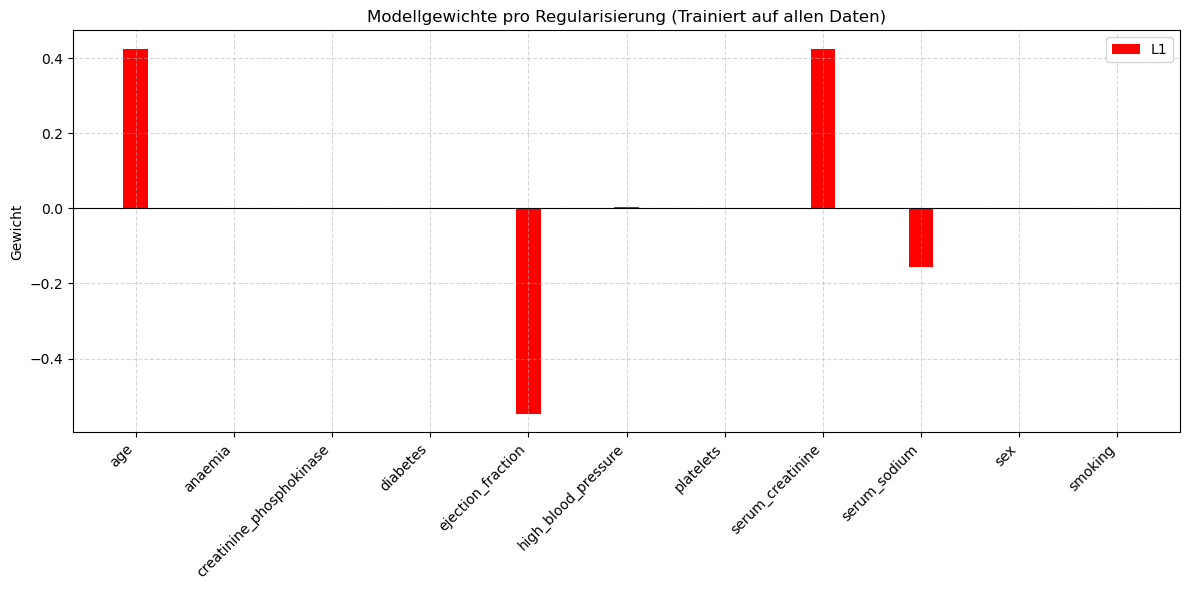

In [16]:
feature_names = X.columns
x = np.arange(len(feature_names))

plt.figure(figsize=(12, 6))

width = 0.25
offsets = { 'l1': 0}
colors = {'l1': 'red'}

for reg_type in [ 'l1']:
    weights = model_weights[reg_type]
    plt.bar(x + offsets[reg_type], weights, width=width, label=reg_type.upper(), color=colors[reg_type])

plt.xticks(x, feature_names, rotation=45, ha='right')
plt.ylabel('Gewicht')
plt.title('Modellgewichte pro Regularisierung (Trainiert auf allen Daten)')
plt.axhline(0, color='black', linewidth=0.8)
plt.legend()
plt.tight_layout()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

One can see, that the performances do not differ too much. So, in particular without regularization we get as good results as without. Now, we want to have a look, if the weights are always predicted in the same way. If so, we would have a more stable model.

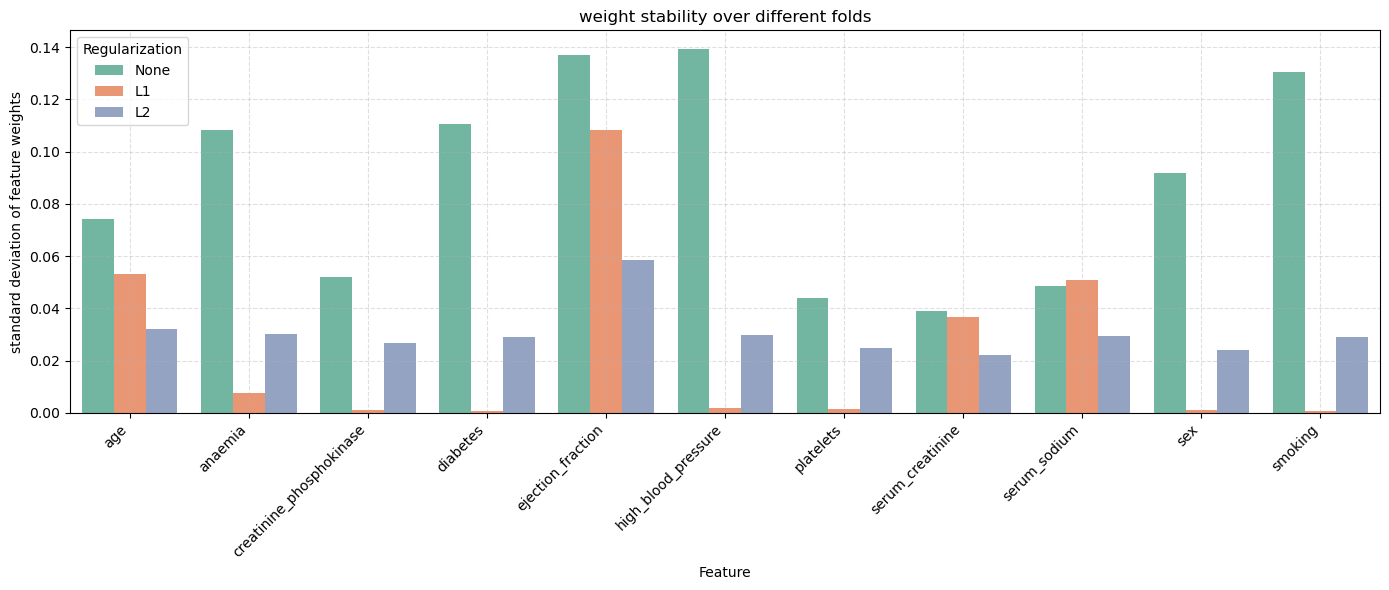

In [17]:
from collections import defaultdict

# Dict: Speichert die Gewichtswerte für jeden Regularisierungstyp
weight_tracking = defaultdict(list)

for reg, lr, alpha in zip([None, 'l1', 'l2'], [0.5, 0.006, 1], [None, 0.025, 0.05]):
    reg_name = 'None' if reg is None else reg.upper()
    
    for fold, (train_index, val_index) in enumerate(kf.split(X,y)):
        X_train_fold = X.iloc[train_index]
        y_train_fold = y.iloc[train_index]

        model = LR_complete(input_dimensions=X.shape[1])
        model.fit(X_train_fold, y_train_fold,
                  regularization=reg, alpha=alpha, learning_rate=lr)

        weights = model.final_weights.detach().numpy().flatten()
        weight_tracking[reg_name].append(weights)

weight_stability = {}

for reg_type, weights_list in weight_tracking.items():
    weights_array = np.vstack(weights_list)  
    std_per_feature = np.std(weights_array, axis=0)
    weight_stability[reg_type] = std_per_feature

# DataFrame zur Visualisierung vorbereiten
plot_df = pd.DataFrame({
    'Feature': np.tile(X.columns, 3),
    'Std': np.concatenate([
        weight_stability['None'],
        weight_stability['L1'],
        weight_stability['L2']
    ]),
    'Regularization': ['None'] * len(X.columns) +
                      ['L1'] * len(X.columns) +
                      ['L2'] * len(X.columns)
})

plt.figure(figsize=(14, 6))
sns.barplot(data=plot_df, x='Feature', y='Std', hue='Regularization', palette='Set2')
plt.title("weight stability over different folds")
plt.xticks(rotation=45, ha='right')
plt.ylabel("standard deviation of feature weights")
plt.xlabel("Feature")
plt.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()


## **Running Time Analysis**

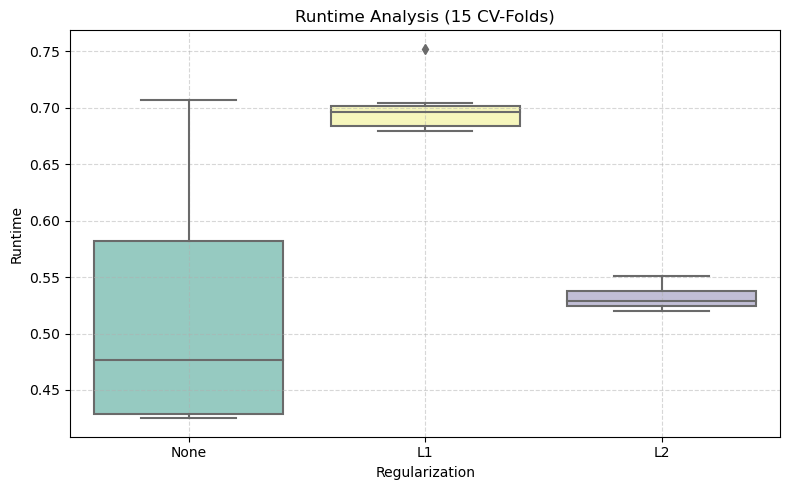

In [18]:
import time

all_running_times = []
reg_names = []

for reg, lr, alpha in zip([None, 'l1', 'l2'], [0.5, 0.006, 1], [None, 0.025, 0.05]):
    running_times = []
    reg_name = 'None' if reg is None else reg.upper()

    for fold, (train_index, val_index) in enumerate(kf.split(X,y)):
        X_train_fold = X.iloc[train_index]
        y_train_fold = y.iloc[train_index]

        model = LR_complete(input_dimensions=X.shape[1])
        
        start_time = time.time()
        model.fit(X_train_fold, y_train_fold,
                  regularization=reg, alpha=alpha, learning_rate=lr)
        end_time = time.time()

        runtime = end_time - start_time
        running_times.append(runtime)

    all_running_times.extend(running_times)
    reg_names.extend([reg_name] * len(running_times))


runtime_df = pd.DataFrame({
    'Regularization': reg_names,
    'Runtime': all_running_times
})


# Use information in model_evaluation
model_evaluation['Running_Time'] = runtime_df['Runtime'].values

plt.figure(figsize=(8, 5))
sns.boxplot(data=runtime_df, x='Regularization', y='Runtime', palette='Set3')
plt.title("Runtime Analysis (15 CV-Folds)")
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

In [19]:
model_evaluation.to_pickle('model_evaluation/logistic_regression_self_made.pkl')

## Visualization in 3D with selected features by L1-Regularization

In [20]:
selected_features = ["age", "ejection_fraction", "serum_creatinine"]
X_sel = X[selected_features]

model = LR_complete(input_dimensions=X_sel.shape[1])
model.fit(X_sel, y, regularization='None', learning_rate=0.7)

In [21]:
model.final_total_loss

0.49889546632766724

In [22]:
w1, w2, w3 = model.final_weights[0].detach().cpu().numpy()

In [23]:
b = model.final_bias.item()

In [24]:
import plotly.express as px
import plotly.graph_objects as go
import pandas as pd

# DataFrame erstellen (falls X_sel noch kein DataFrame ist)
df = X_sel.copy()
df["label"] = y.values  # Klassenbeschriftung hinzufügen

# Meshgrid für x und y erzeugen (x = age, y = ejection_fraction)
x_vals = np.linspace(df['age'].min(), df['age'].max(), 30)
y_vals = np.linspace(df['ejection_fraction'].min(), df['ejection_fraction'].max(), 30)
x_mesh, y_mesh = np.meshgrid(x_vals, y_vals)

# z aus Gleichung berechnen: w1*x + w2*y + w3*z + b = 0 → z = -(w1*x + w2*y + b) / w3
z_mesh = -(w1 * x_mesh + w2 * y_mesh + b) / w3

# Punkte plotten
scatter = go.Scatter3d(
    x=df['age'],
    y=df['ejection_fraction'],
    z=df['serum_creatinine'],
    mode='markers',
    marker=dict(size=4, color=df['label'], colorscale='Viridis'),
    name='Datenpunkte'
)

# Ebene plotten
plane = go.Surface(
    x=x_mesh,
    y=y_mesh,
    z=z_mesh,
    colorscale=[[0, 'red'], [1, 'red']],  # feste Farbe
    showscale=False,
    opacity=0.4,
    name='Decision Boundary'
)


fig = go.Figure(data=[scatter, plane])

min_z = df['serum_creatinine'].min() - 0.5
max_z = df['serum_creatinine'].max() + 0.5

fig.update_layout(
    height = 800,
    width = 800,
    scene=dict(
        xaxis_title='age',
        yaxis_title='ejection_fraction',
        zaxis_title='serum_creatinine',
        zaxis=dict(range=[min_z, max_z])
    ),
    title="3D-Logistische Regression mit Entscheidungsgrenze"
)


fig.show()

## Model evaluation with predefined functions

In [25]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, KFold, cross_validate, StratifiedKFold


inner_cv = StratifiedKFold(n_splits = 3, shuffle=True,random_state=42)
outer_cv = StratifiedKFold(n_splits = 10, shuffle=True,random_state=42)

results = []

for regularization in [None, 'l1', 'l2']:
    # Solver je nach Penalty wählen
    if regularization == 'l1':
        solver = 'liblinear'
    else:
        solver = 'lbfgs'
    
    param_grid = {
        'C': [0.001, 0.025, 0.05, 0.01, 0.1, 1],
    }

    grid_LR = GridSearchCV(
        estimator=LogisticRegression(penalty=regularization, solver=solver, max_iter=1000),
        param_grid=param_grid,
        scoring='roc_auc',
        cv=inner_cv
    )

    scores_LR = cross_validate(
        grid_LR, X=X, y=y,
        cv=outer_cv,
        scoring=["roc_auc", "accuracy"],
        return_train_score=True
    )

    for i in range(len(scores_LR['test_accuracy'])):
        if regularization is None:
            regularization = 'Logistic Regression'
        results.append({
            "Fold": i + 1,
            "Modell": regularization,
            "ROC AUC": scores_LR["test_roc_auc"][i],
            "Accuracy": scores_LR["test_accuracy"][i]
        })

df = pd.DataFrame(results)

C:\Users\User\AppData\Roaming\Python\Python311\site-packages\sklearn\linear_model\_logistic.py:1207: UserWarning:

Setting penalty=None will ignore the C and l1_ratio parameters

C:\Users\User\AppData\Roaming\Python\Python311\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\Users\User\AppData\Roaming\Python\Python311\site-packages\sklearn\linear_model\_logistic.py:1207: UserWarning:

Setting penalty=None will ignore the C and l1_ratio parameters

C:\Users\User\AppData\Roaming\Python\Python311\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\Users\User\AppData\Roaming\Python\Python311\site-packages\sklearn\linear_model\_logistic.py:1207: UserWarning:

Setting penalty=None 

In [28]:
df.to_pickle("model_evaluation/logistic_regression.pkl")